- PostgreSQL 버퍼 관리자는 '버퍼 테이블', '버퍼 설명자' 및 '버퍼 풀'의 세 가지 계층으로 구성

**Buffer manager's three-layer structure.**

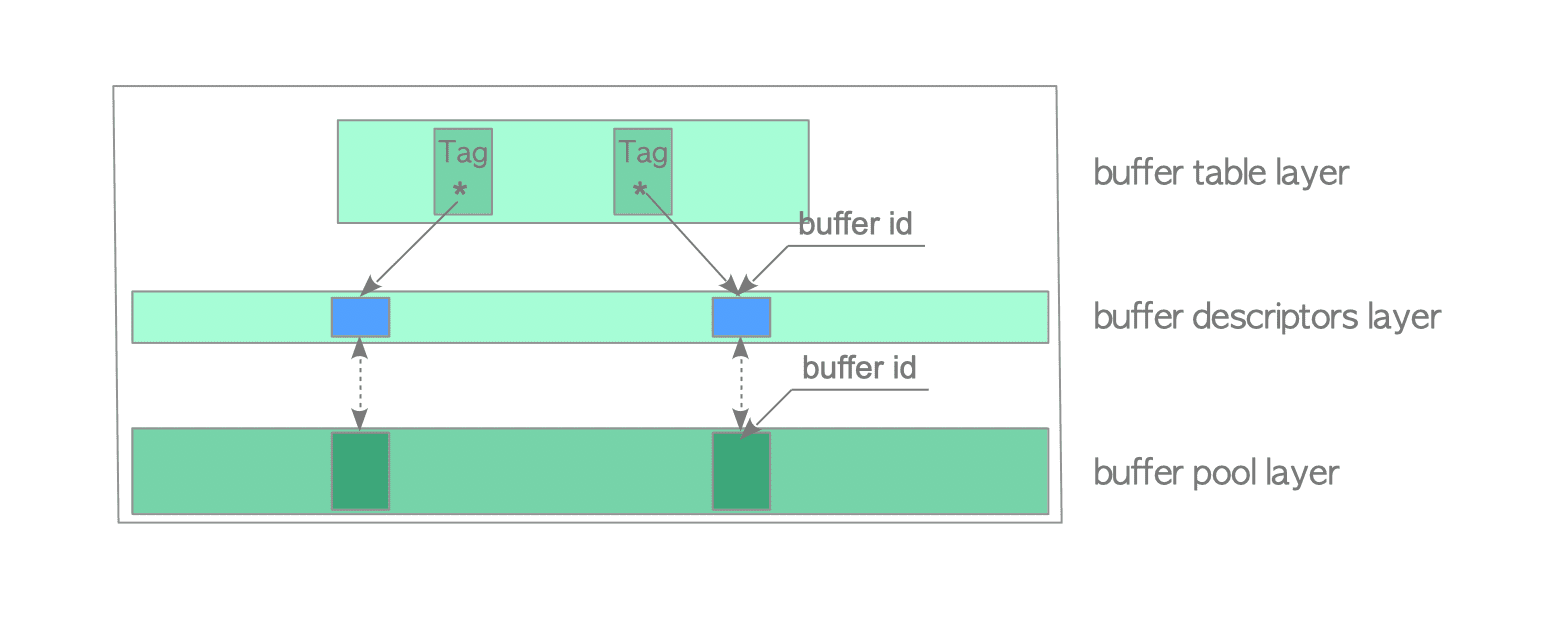

- 버퍼 풀 : 데이터 파일 페이지를 저장하는 배열입니다. 배열의 각 슬롯을 buffer_id 라고 함.

- 버퍼 설명자 : 버퍼 설명자의 배열입니다. 각 설명자는 버퍼 풀 슬롯과 일대일 대응을 가지며 해당 슬롯에 저장된 페이지의 메타데이터를 보유함
  - '버퍼 설명자 레이어'라는 용어는 편의상 채택되었으며 이 문서에서만 사용.

- 버퍼 테이블 : 저장된 페이지의 buffer_tags와 저장된 페이지의 각 메타데이터를 보유하는 설명자의 buffer_id 간의 관계를 저장하는 해시 테이블

# **Buffer Table**

- 버퍼 테이블은 논리적으로 해시 함수, 해시 버킷 슬롯, 데이터 항목의 세 부분으로 나눌 수 있음

- 내장된 해시 함수는 buffer_tags를 해시 버킷 슬롯에 매핑.
- 해시 버킷 슬롯의 개수가 버퍼 풀 슬롯의 개수보다 많아도 충돌이 발생할 수 있음.
- 따라서 버퍼 테이블은 충돌을 해결하기 위해 연결된 목록을 사용한 별도의 연결 방법을 사용.
- 데이터 항목이 동일한 버킷 슬롯에 매핑되면 이 방법은 그림과 같이 동일한 연결 목록에 항목을 저장.



**Buffer table.**

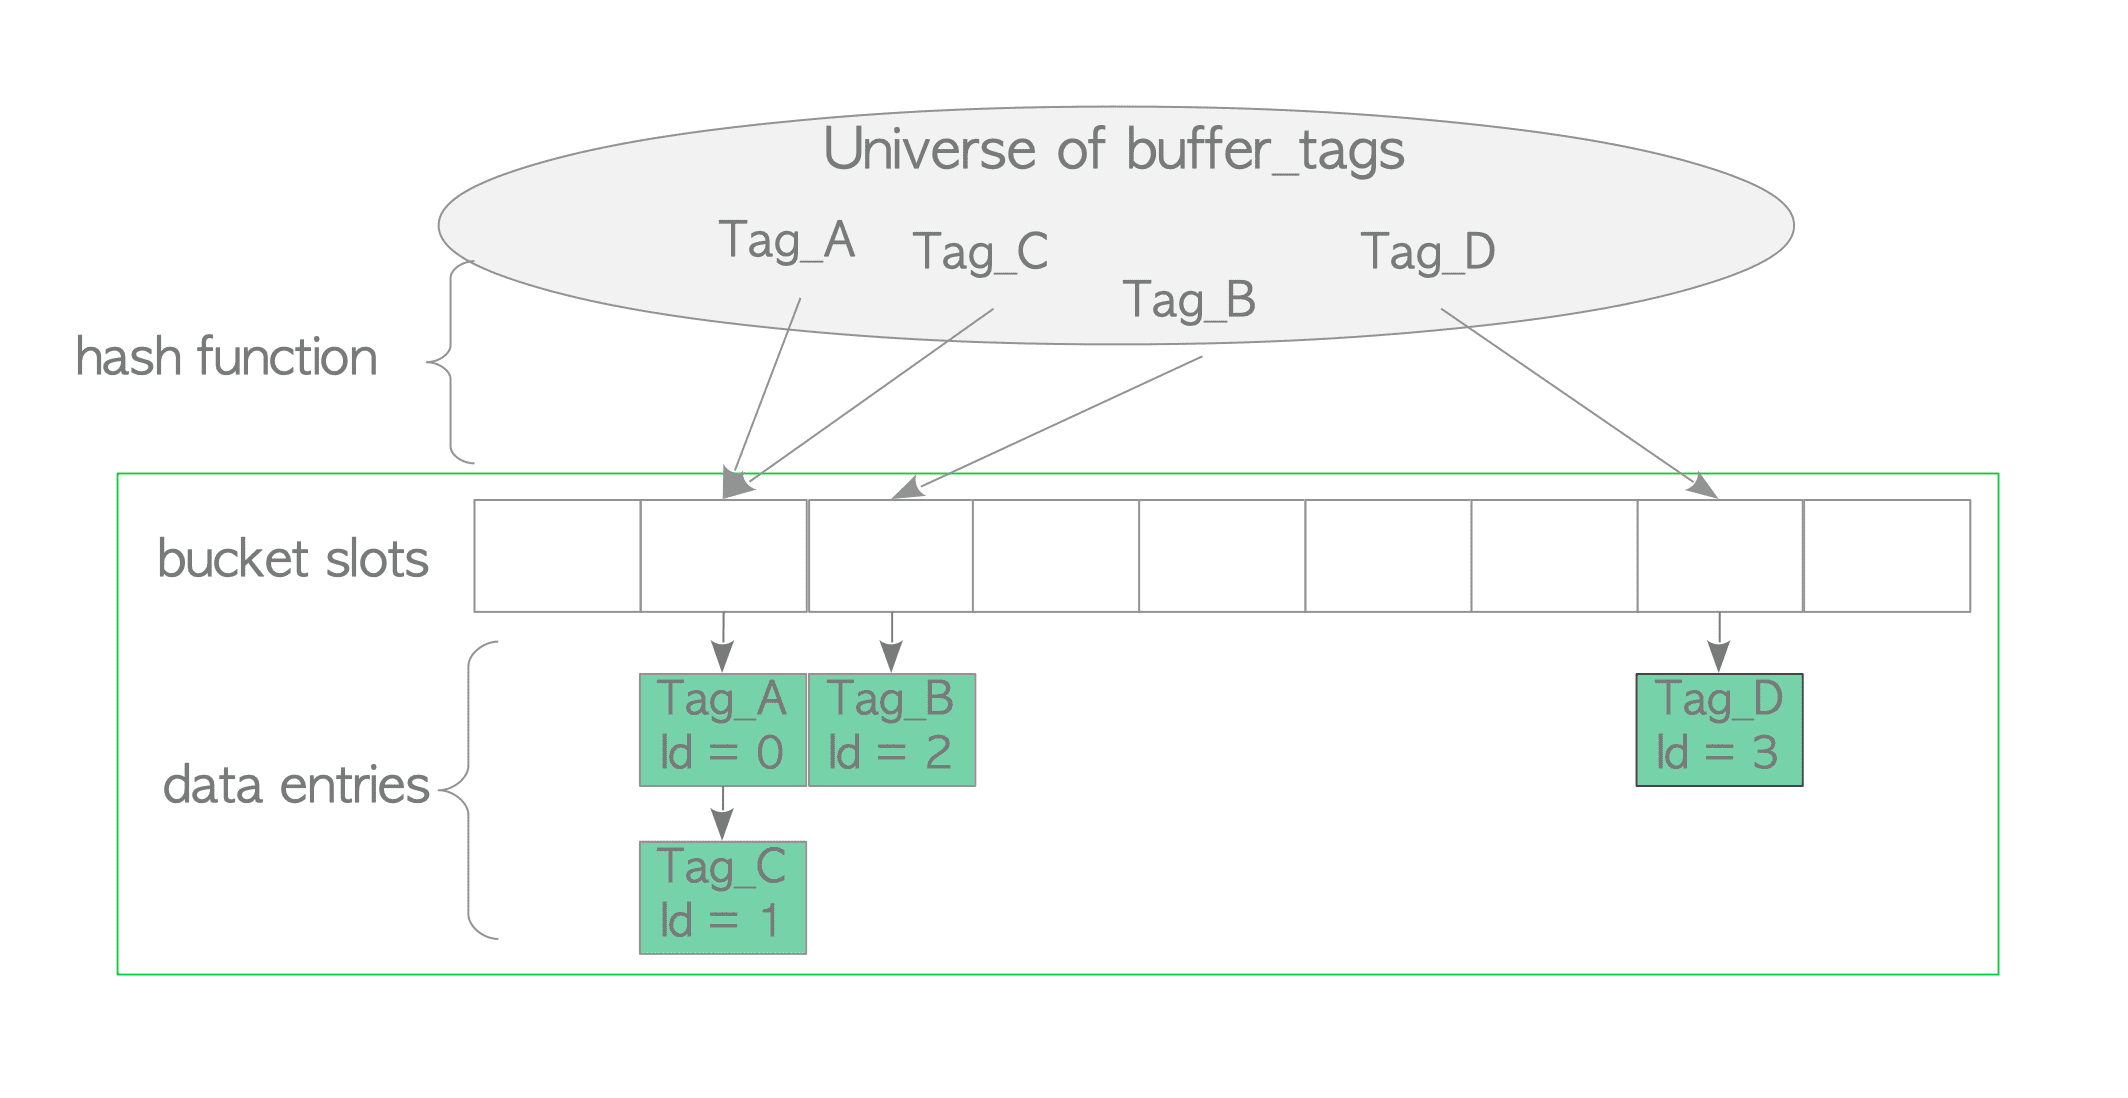

- 데이터 항목은 페이지의 buffer_tag와 페이지의 메타데이터를 보유하는 설명자의 buffer_id라는 두 가지 값으로 구성
  - 예를 들어, 데이터 항목 'Tag_A, id=1'은 buffer_id가 '1'인 버퍼 설명자가 Tag_A로 태그된 페이지의 메타데이터를 저장한다는 의미

**Hash Function**

- 해시 함수는 calc_bucket() 및 hash() 의 복합 함수

**pseudo-function**


```
uint32 bucket_slot = calc_bucket(unsigned hash(BufferTag buffer_tag), uint32 bucket_size)
```

# **Buffer Descriptor**

- 버전 9.6에서는 버퍼 설명자의 구조가 개선.
- 먼저 버전 9.5 이하의 버퍼 설명자를 설명한 다음 버전 9.6 이상의 버퍼 설명자가 이전 버전과 어떻게 다른지 설명.


**버전 9.5 이하**

- 버전 9.5 이하의 버퍼 설명자 구조는 해당 버퍼 풀 슬롯에 저장된 페이지의 메타데이터를 보유.
- 버퍼 설명자 구조는 다음과 같이 정의
  - BufferDesc구조. 다음은 주요 필드 중 일부.

**버퍼 설명**

```
 /*
 * Flags for buffer descriptors
 *
 * Note: TAG_VALID essentially means that there is a buffer hashtable
 * entry associated with the buffer's tag.
 */
#define BM_DIRTY                (1 << 0)    /* data needs writing */
#define BM_VALID                (1 << 1)    /* data is valid */
#define BM_TAG_VALID            (1 << 2)    /* tag is assigned */
#define BM_IO_IN_PROGRESS       (1 << 3)    /* read or write in progress */
#define BM_IO_ERROR             (1 << 4)    /* previous I/O failed */
#define BM_JUST_DIRTIED         (1 << 5)    /* dirtied since write started */
#define BM_PIN_COUNT_WAITER     (1 << 6)    /* have waiter for sole pin */
#define BM_CHECKPOINT_NEEDED    (1 << 7)    /* must write for checkpoint */
#define BM_PERMANENT            (1 << 8)    /* permanent relation (not unlogged) */

src/include/storage/buf_internals.h
typedef struct sbufdesc
{
   BufferTag    tag;                 /* ID of page contained in buffer */
   BufFlags     flags;               /* see bit definitions above */
   uint16       usage_count;         /* usage counter for clock sweep code */
   unsigned     refcount;            /* # of backends holding pins on buffer */
   int          wait_backend_pid;    /* backend PID of pin-count waiter */
   slock_t      buf_hdr_lock;        /* protects the above fields */
   int          buf_id;              /* buffer's index number (from 0) */
   int          freeNext;            /* link in freelist chain */

   LWLockId     io_in_progress_lock; /* to wait for I/O to complete */
   LWLockId     content_lock;        /* to lock access to buffer contents */
} BufferDesc;
```


- 태그는 해당 버퍼 풀 슬롯에 저장된 페이지의 buffer_tag를 보유. (버퍼 태그는 섹션 8.1.2 에 정의되어 있음.)

- buf_id는 설명자를 식별.
  - 해당 버퍼 풀 슬롯의 buffer_id 와 동일 .

**refcount는 현재 연결된 저장된 페이지에 액세스하고 있는 PostgreSQL 프로세스의 수를 보유.**

- 핀 수 라고도 함.
- PostgreSQL 프로세스가 저장된 페이지에 액세스할 때 참조 개수는 1씩 증가해야 함(refcount++).
- 해당 페이지에 접속한 후에는 refcount를 1씩 줄여야 함(refcount-).
- 참조 횟수가 0이면 연결된 저장된 페이지가 고정 해제 되어 현재 액세스되고 있지 않음을 의미.
  - 그렇지 않으면 고정

- Usage_count는 해당 버퍼 풀 슬롯에 로드된 이후 연결된 저장된 페이지에 액세스한 횟수를 보유.
  - 이는 페이지 교체 알고리즘에 사용됨.

- content_lock 및 io_in_progress_lock은 연결된 저장된 페이지에 대한 액세스를 제어하는 ​​데 사용되는 경량 잠금.

- 플래그는 연관된 저장된 페이지의 여러 상태를 보유할 수 있음.

**주요 상태**

- 더티 비트는 저장된 페이지가 더티(dirty)함을 나타냄.

- 유효한 비트는 저장된 페이지가 유효한지, 즉 읽거나 쓸 수 있는지 여부를 나타냄.
  - 이 비트가 유효한 경우 해당 버퍼 풀 슬롯은 페이지를 저장하고 설명자는 페이지 메타데이터를 보유하며 저장된 페이지를 읽거나 쓸 수 있음.
  - 이 비트가 유효하지 않은 경우 설명자는 메타데이터를 보유하지 않으며 저장된 페이지를 읽거나 쓸 수 없음.

- io_in_progress 비트는 버퍼 관리자가 스토리지에서 관련 페이지를 읽거나 쓰고 있는지 여부를 나타냄.

- buf_hdr_lock은 flags, Usage_count, refcount 필드를 보호하는 스핀 잠금.

- freeNext는 다음 하위 섹션에서 설명하는 freelist를 생성하기 위한 다음 설명자를 가리키는 포인터 .

**버전 9.6 이상**

- 버퍼 설명자 구조는 다음과 같이 정의.
  - BufferDesc구조.

**버퍼 설명**

```
/*
 * Flags for buffer descriptors
 *
 * Note: BM_TAG_VALID essentially means that there is a buffer hashtable
 * entry associated with the buffer's tag.
 */
#define BM_LOCKED		(1U << 22)	/* buffer header is locked */
#define BM_DIRTY		(1U << 23)	/* data needs writing */
#define BM_VALID		(1U << 24)	/* data is valid */
#define BM_TAG_VALID		(1U << 25)	/* tag is assigned */
#define BM_IO_IN_PROGRESS	(1U << 26)	/* read or write in progress */
#define BM_IO_ERROR		(1U << 27)	/* previous I/O failed */
#define BM_JUST_DIRTIED		(1U << 28)	/* dirtied since write started */
#define BM_PIN_COUNT_WAITER	(1U << 29)	/* have waiter for sole pin */
#define BM_CHECKPOINT_NEEDED	(1U << 30)	/* must write for checkpoint */
#define BM_PERMANENT		(1U << 31)	/* permanent buffer (not unlogged,
						 * or init fork) */

#define PG_HAVE_ATOMIC_U32_SUPPORT
typedef struct pg_atomic_uint32
{
	volatile uint32 value;
} pg_atomic_uint32;


typedef struct BufferDesc
{
	BufferTag	tag;			/* ID of page contained in buffer */
	int		buf_id;			/* buffer's index number (from 0) */

	/* state of the tag, containing flags, refcount and usagecount */
	pg_atomic_uint32 state;

	int		wait_backend_pgprocno;	/* backend of pin-count waiter */
	int		freeNext;		/* link in freelist chain */
	LWLock		content_lock;	/* to lock access to buffer contents */
} BufferDesc;
```

- 태그는 해당 버퍼 풀 슬롯에 저장된 페이지의 buffer_tag를 보유.

- buf_id는 설명자를 식별.

- content_lock은 연결된 저장된 페이지에 대한 액세스를 제어하는 ​​데 사용되는 경량 잠금.

- freeNext는 freelist를 생성하기 위한 다음 설명자를 가리키는 포인터

- 상태는 refcount 및 Usage_count와 같은 연관된 저장 페이지의 여러 상태 및 변수를 보유할 수 있음.

- 플래그, Usage_count 및 refcount 필드는 CPU 원자성 작업을 사용하기 위해 단일 32비트 데이터(상태)로 결합되었음.
  - 따라서 io_in_progress_lock 및 스핀 잠금(buf_hdr_lock)은 더 이상 이러한 값을 보호할 필요가 없으므로 제거되었음.

**Atomic Operations**

- Atomic OperationsCPU 원자성 작업은 소프트웨어에 의한 데이터 독점 제어 대신 하드웨어 적용 독점 제어 및 원자성 읽기-수정-쓰기 작업을 사용하여 효율적으로 수행됨.

**Info**

- Atomic OperationsBufferDesc 구조는 src/include/storage/buf_internals.h 에 정의되어 있음

**Descriptor States**

- 다음 설명을 단순화하기 위해 다음과 같이 세 가지 설명자 상태를 정의.

- 비어 있음 : 해당 버퍼 풀 슬롯이 페이지를 저장하지 않는 경우(예: refcount 및 Usage_count가 0인 경우) 이 설명자의 상태는 비어 있음.

- 고정됨 : 해당 버퍼 풀 슬롯이 페이지를 저장하고 PostgreSQL 프로세스가 페이지에 액세스하는 경우(예: refcount 및 Usage_count가 1보다 크거나 같음) 이 버퍼 설명자의 상태는 고정됨

- Unpinned : 해당 버퍼 풀 슬롯이 페이지를 저장하지만 PostgreSQL 프로세스가 페이지에 액세스하지 않는 경우(즉, Usage_count가 1보다 크거나 같지만 refcount가 0인 경우) 이 버퍼 설명자의 상태는 unpinned

- 각 설명자는 위의 상태 중 하나를 갖음.
  - 설명자 상태는 특정 조건에 따라 변경됩니다.

-  버퍼 설명자의 상태는 색상이 지정된 상자로 표시됨.

> - (흰색) 비어 있음
> - (파란색) 고정됨
> - (아쿠아 블루) 고정 해제됨
또한, 더티 페이지(dirty page)는 'X'로 표시된다. 예를 들어 고정되지 않은 더티 설명자는  X  로 표시됩니다 .

# **Buffer Descriptors Layer**

- 버퍼 설명자의 컬렉션은 이 문서에서 버퍼 설명자 레이어 라고 하는 배열을 형성

- PostgreSQL 서버가 시작되면 모든 버퍼 설명자의 상태는 '비어 있음'.
- PostgreSQL에서 이러한 설명자는 freelist 라는 연결 목록으로 구성됨

**Buffer manager initial state.**

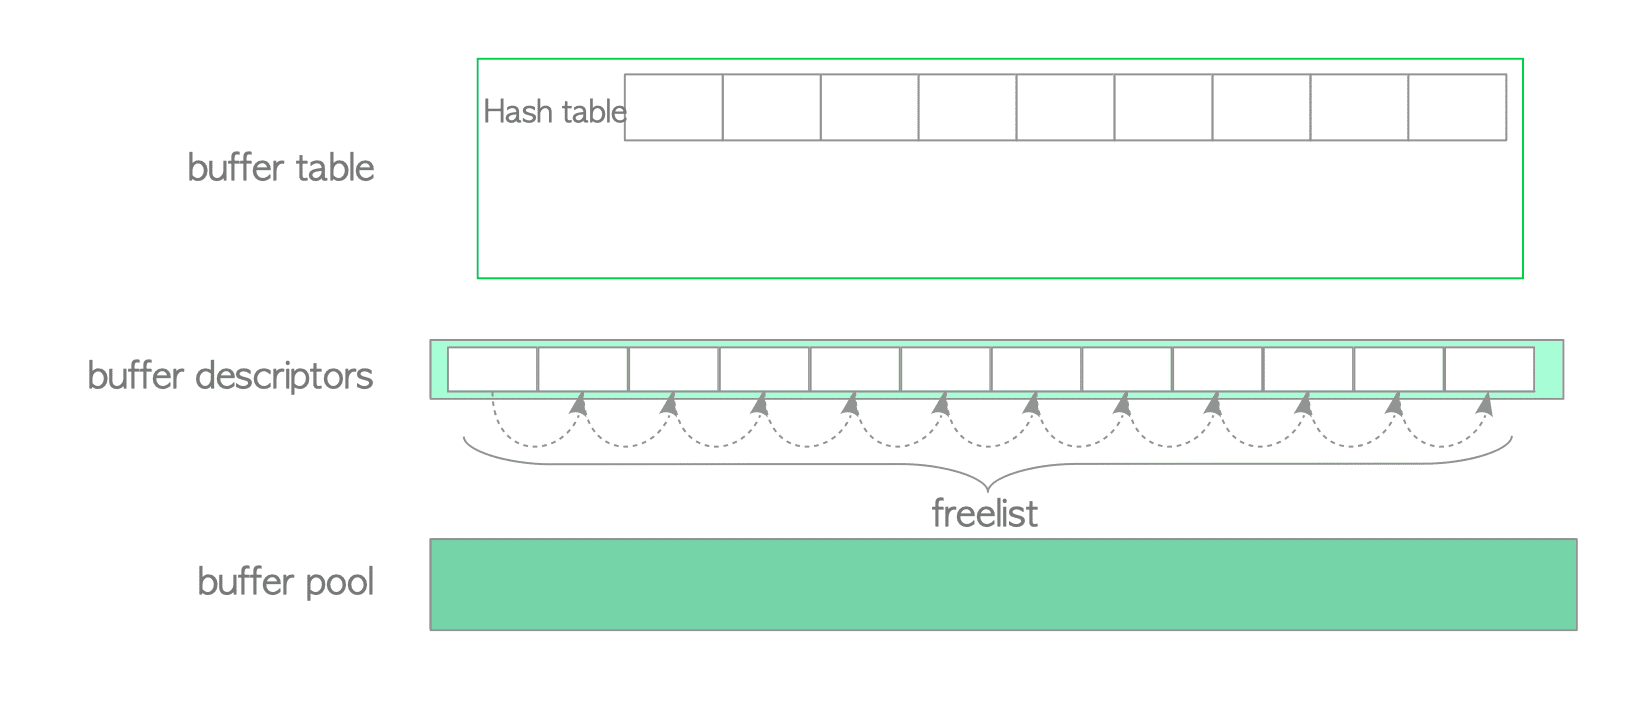

**Note**

- PostgreSQL의 freelist는 Oracle의 freelist 와 완전히 다른 개념이라는 점에 유의하는 것이 중요
- PostgreSQL의 freelist는 단순히 빈 버퍼 설명자의 연결된 목록.
- PostgreSQL에서는 FSM(Freespace Map)이 Oracle의 freelist와 동일한 목적으로 사용됨.

- 그림은 첫 번째 페이지가 로드되는 방식을 보여줌.

1. freelist의 상단에서 빈 설명자를 검색하고 고정(즉, refcount와 Usage_count를 1씩 늘림).

2. 첫 번째 페이지의 태그를 검색된 설명자의 buffer_id에 매핑하는 버퍼 테이블에 새 항목을 삽입.

3. 스토리지의 새 페이지를 해당 버퍼 풀 슬롯에 로드.

4. 새 페이지의 메타데이터를 검색된 설명자에 저장.

- 두 번째 및 후속 페이지도 비슷한 방식으로 로드됨.


**Loading the first page.**

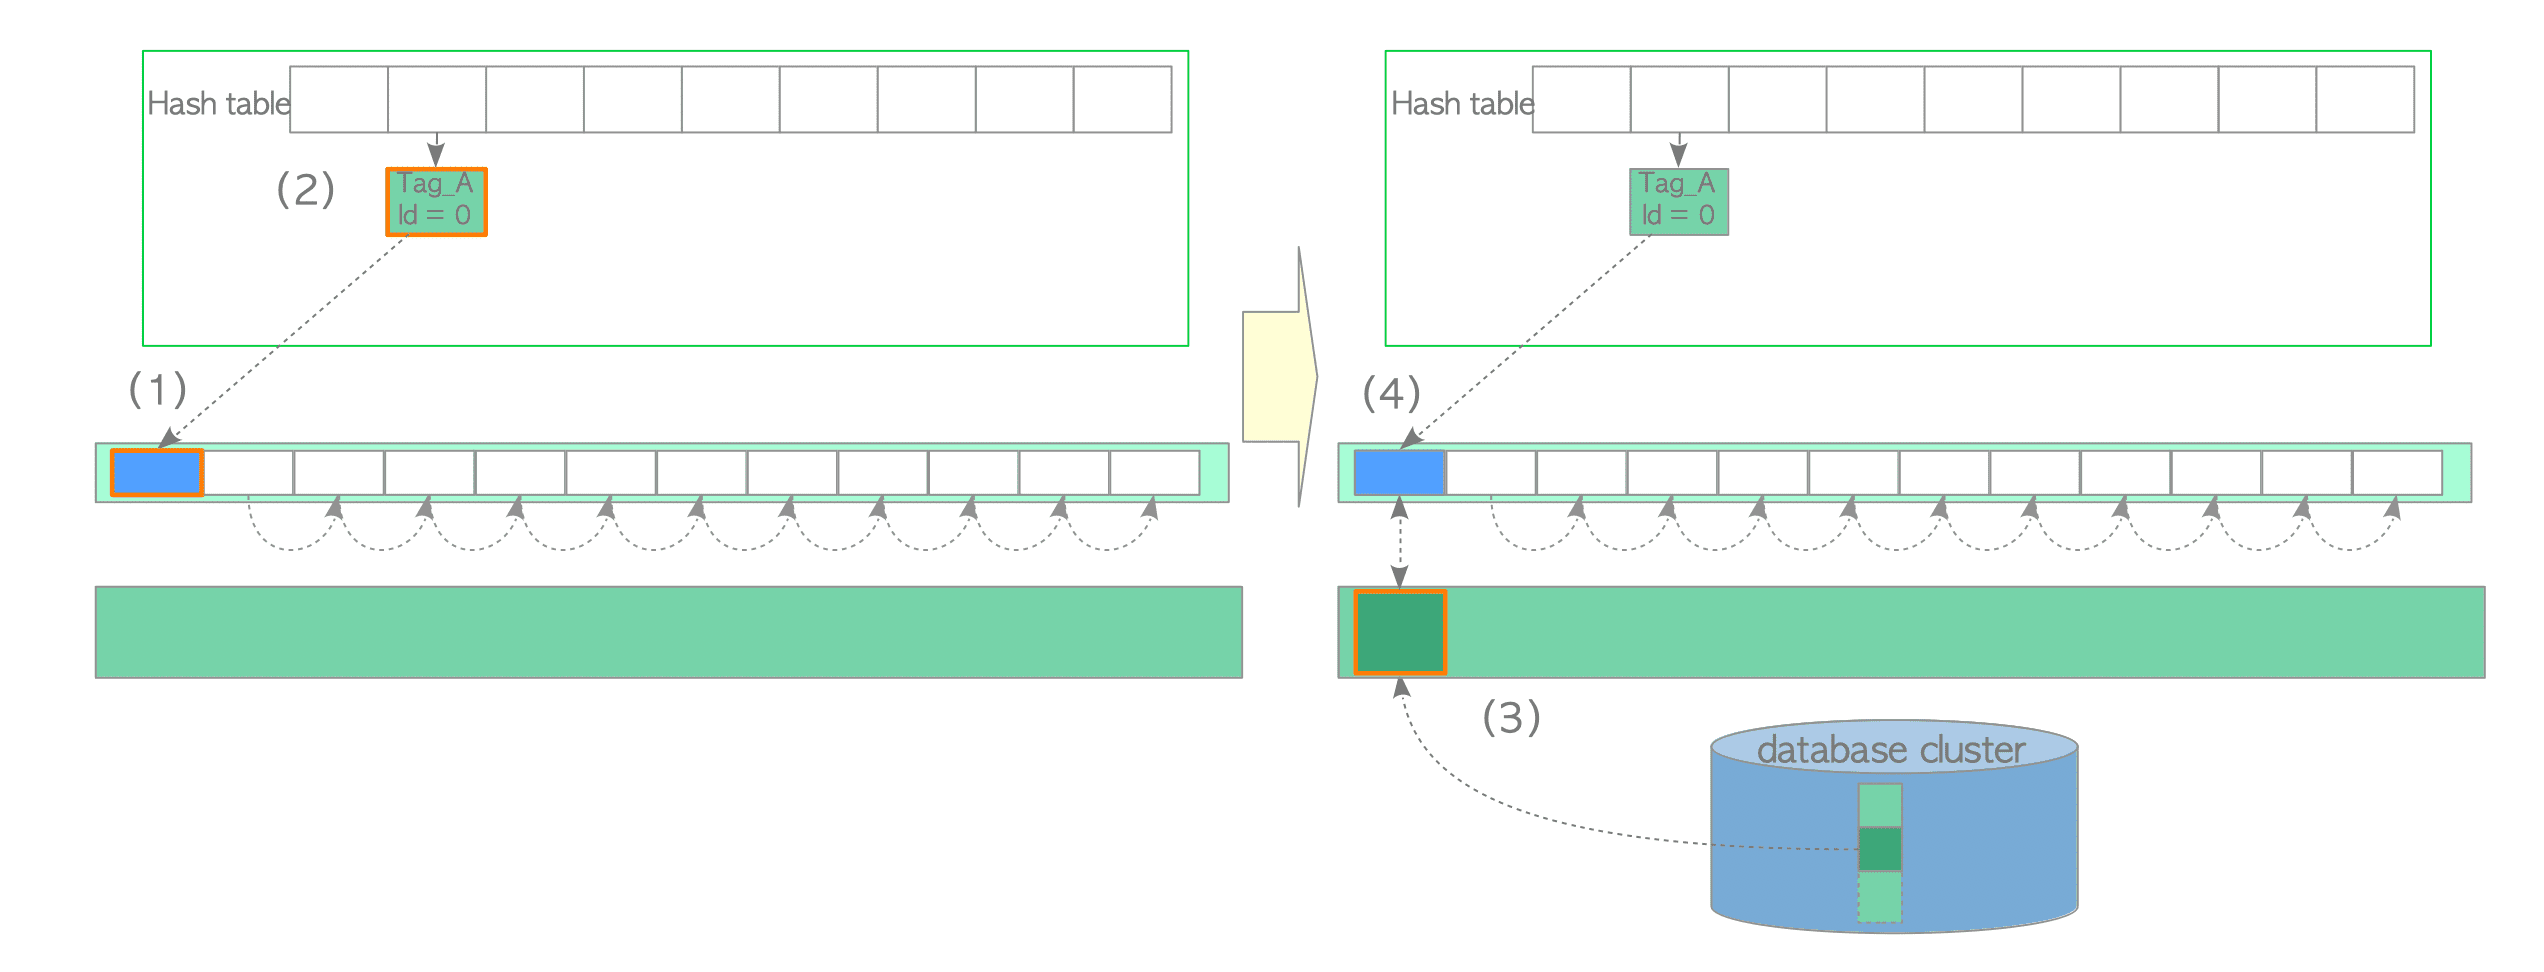

- freelist에서 검색된 설명자는 항상 페이지의 메타데이터를 보유.
- 즉, 비어 있지 않은 설명자는 일단 사용되면 freelist로 돌아가지 않음.
  - 그러나 다음 중 하나가 발생하면 해당 설명자가 다시 freelist에 추가되고 설명자 상태는 '비어 있음'으로 설정됨.

1. 테이블이나 인덱스가 삭제됨.
2. 데이터베이스가 삭제됨.
3. 테이블이나 인덱스는 VACUUM FULL 명령을 사용하여 정리됨.

**Why empty descriptors comprise the freelist?**

- freelist는 첫 번째 설명자를 즉시 ​​검색할 수 있도록 생성됨.
- 이는 동적 메모리 리소스 할당의 일반적인 관행.

- 버퍼 설명자 계층에는 부호 없는 32비트 정수 변수(예: nextVictimBuffer )가 포함되어 있음
  - 페이지 교체 알고리즘에 사용됨

# **Buffer Pool**

- 버퍼 풀은 테이블, 인덱스 등의 데이터 파일 페이지를 저장하는 간단한 배열
  - 버퍼 풀 배열의 인덱스를 buffer_id 라고 함 .

- 버퍼 풀 슬롯 크기는 8KB로 페이지 크기와 같음.
  - 따라서 각 슬롯은 전체 페이지를 저장할 수 있음.